Goals of this notebook
---
* Inspect how the performances of different DDPC strategies (SPC, C-SPC, DeePC) evolve when the size of the training data $N_bar$ changes.

For more details about SPC, C-SPC, DeePC see 

On the equivalence of direct and indirect data-driven predictive control approaches   
_Per Mattson, Fabio Bonassi, Valentina Breschi, Thomas B. Schön_  
Pre-print, 2024. [arXiv: 2403.05860](https://arxiv.org/abs/2403.05860)

In [1]:
import pandas as pd    
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# Default style for plots
# Latex for labels
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "axes.labelsize": 23,
          "axes.titlesize": "xx-large",
          "xtick.labelsize": 18,
          "ytick.labelsize": 18,
          'xtick.minor.width': 1,
          'ytick.minor.width' : 0.8,
          'xtick.major.width': 2,
          'ytick.major.width' : 2,
          'xtick.major.size': 6,
          'ytick.major.size' : 6,
            'xtick.minor.size': 4,
            'ytick.minor.size' : 4,
          'grid.color': 'grey',
          'grid.linewidth': 0.4,
          'grid.alpha': 0.35,
          'grid.linestyle': '--',
          "text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"]}

fig_shape = (10, 4)
lambda_colors = ["tab:blue", "tab:purple", "tab:green",  "tab:orange", "tab:brown",  "tab:olive", "tab:pink", "tab:gray", "tab:cyan"]

plt.rcParams.update(params)

In [10]:
di = 'out'

In [11]:
import re

# Empty dataframe
res = None

for subfolder in Path(di).iterdir():
    if subfolder.is_dir():
        # Extract the value of rho from the subfolder name
        match = re.search(r'N_bar(\d*)_\d+', subfolder.name)
        if match:
            N_bar_value = int(match.group(1))  # Convert the matched string to an integer
            
        r_ = pd.read_csv(subfolder / 'results.csv')
        r_['N_bar'] = N_bar_value
        if res is None:
            # Add the column rho with the value of rho
            res = r_
        else:
            res = res._append(r_, ignore_index=True)
res = res.drop(columns=res.columns[0])
res['J_tot'] = res['E[J_tr]'] + res['E[J_co]']
res['Delta_tot'] = res['E[Delta_tr]'] + res['E[Delta_co]']

In [12]:
def plot_wrt_N_bar(res, metric_mean, ylabel: str = None, ylim = None, ylog: bool = True, std: bool = False, legend: bool = False, exclude_lambdas: list = []):    
    deepc = res[res['Controller'] == 'DeePC']
    d_spc = res[res['Controller'] == 'SPC']
    d_cspc = res[res['Controller'] == 'C-SPC']

    fig, ax = plt.subplots(figsize=fig_shape)
    i = 0
    for lam in deepc['lambda'].sort_values().unique():
        if lam in exclude_lambdas:
            continue
        col = lambda_colors[i]
        i += 1

        d = deepc[deepc['lambda'] == lam]
        # Group by lambda making it the index, and computing the mean of the column E[slack_mse]
        res_metric = d.groupby('N_bar')[metric_mean].mean() 
        ax.plot(res_metric.index, res_metric, label=f'$\lambda={lam:.2f}$', color=col)

        if std:
            res_std_dwn = d.groupby('N_bar')[metric_mean].quantile(0.1)
            res_std_up = d.groupby('N_bar')[metric_mean].quantile(0.9)
            ax.fill_between(res_metric.index, res_std_dwn, res_std_up, alpha=0.4, color=col)
        

    res_metric = d_spc.groupby('N_bar')[metric_mean].mean()
    ax.plot(res_metric.index, res_metric, label='SPC', color='black', linestyle=':', linewidth=3)
    if std:
        res_std_dwn = d_spc.groupby('N_bar')[metric_mean].quantile(0.1)
        res_std_up = d_spc.groupby('N_bar')[metric_mean].quantile(0.9)
        ax.fill_between(res_metric.index, res_std_dwn, res_std_up, alpha=0.2, color='black')

    res_metric = d_cspc.groupby('N_bar')[metric_mean].mean()
    ax.plot(res_metric.index, res_metric, label='C-SPC', color='tab:red', linestyle='-.', linewidth=2.2)
    if std:
        res_std_dwn = d_cspc.groupby('N_bar')[metric_mean].quantile(0.1)
        res_std_up = d_cspc.groupby('N_bar')[metric_mean].quantile(0.9)
        ax.fill_between(res_metric.index, res_std_dwn, res_std_up, alpha=0.2, color='tab:red')
    
    if ylim is not None:
        ax.set_ylim(ylim)
    
    n_el = len(deepc['lambda'].unique()) + 2
    ax.set_xlim(10 ** np.floor(np.log10(res_metric.index.min())), res_metric.index.max())
    ax.set_xlabel(r'$\bar{N}$')
    ax.set_xscale('log')
    ax.grid(which='both')
    ax.minorticks_on()
    if ylog:
        ax.set_yscale('log')    

    ax.set_ylabel(ylabel if ylabel else metric_mean)
    if legend:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=n_el, framealpha=1, fancybox=False)

    return fig

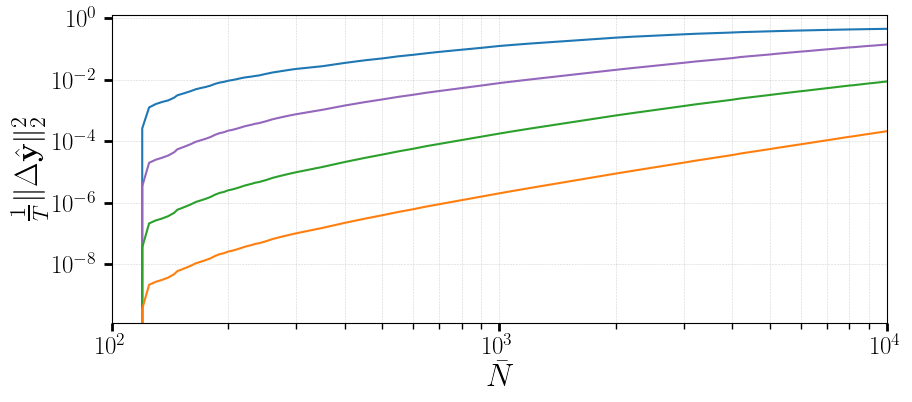

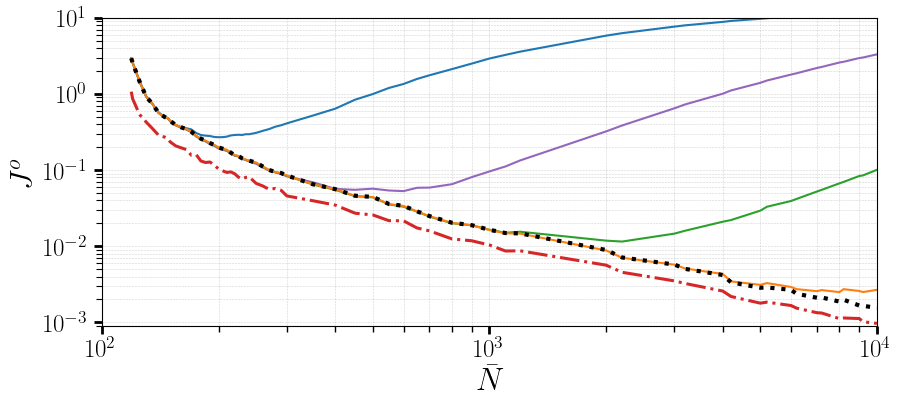

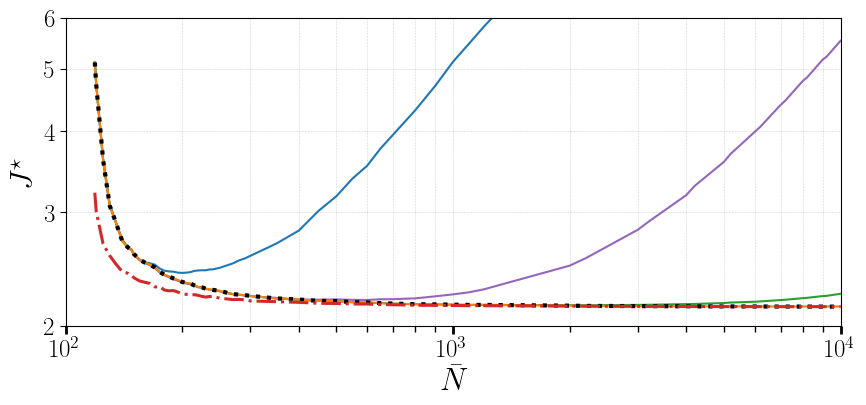

In [13]:
plot_std = False    # Show the standard deviation/quantiles of the lines
exclude_lambdas = [0.1] # It's too off, so we just exclude it for better plotting
fig_slack_ms = plot_wrt_N_bar(res, 'E[slack_mse]', ylabel=r'$\frac{1}{T}\|\Delta \hat{\textrm{\bfseries y}} \|_2^2$', std=plot_std, exclude_lambdas=exclude_lambdas)
fig_oracle = plot_wrt_N_bar(res, 'Delta_tot', ylabel=r'$J^o$', std=plot_std, exclude_lambdas=exclude_lambdas, ylim=(9e-4, 10), ylog=True)
fig_J_crit = plot_wrt_N_bar(res, 'J_tot', ylabel=r'$J^\star$', std=plot_std, exclude_lambdas=exclude_lambdas, ylim=(2, 6.0), ylog=True)
fig_J_crit.axes[0].yaxis.set_minor_formatter(plt.FuncFormatter(lambda x, _: '{}'.format(int(x))))